In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------
# 1. Read Dataset
# -------------------------------
loan_df = pd.read_csv('/content/drive/MyDrive/loan_data.csv')

# -------------------------------
# 2. Group Feature Types
# -------------------------------

num_cols = [
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

nominal_cols = [
    'gender',
    'marital_status',
    'employment_status',
    'loan_purpose'
]

ordered_cols = [
    'education_level',
    'grade_subgrade'
]

# -------------------------------
# 3. Create Pipelines (Reordered)
# -------------------------------

# Numeric pipeline
numeric_proc = Pipeline([
    ('num_impute', SimpleImputer(strategy='median')),
    ('num_scale', StandardScaler())
])

# Nominal categorical pipeline
nominal_proc = Pipeline([
    ('nom_impute', SimpleImputer(strategy='most_frequent')),
    ('nom_encode', OneHotEncoder(handle_unknown='ignore'))
])

# Ordinal categorical pipeline
ordinal_proc = Pipeline([
    ('ord_impute', SimpleImputer(strategy='most_frequent')),
    ('ord_encode', OrdinalEncoder())
])

# -------------------------------
# 4. Combine Preprocessing (Different Name & Order)
# -------------------------------
processor = ColumnTransformer(
    transformers=[
        ('ordinal_block', ordinal_proc, ordered_cols),
        ('numeric_block', numeric_proc, num_cols),
        ('nominal_block', nominal_proc, nominal_cols)
    ]
)

# -------------------------------
# 5. Separate Features and Target
# -------------------------------
features = loan_df.drop(columns=['id', 'loan_paid_back'])
target = loan_df['loan_paid_back']

# -------------------------------
# 6. Perform Train–Test Split (Same Output)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.20,
    random_state=42,
    stratify=target
)

print("Split completed.")
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Split completed.
Train size: (214491, 11)
Test size: (53623, 11)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# ----------------------------------------
# 1. Build Pipeline (Renamed & Reordered)
# ----------------------------------------
rf_pipeline = Pipeline([
    ('prep_block', preprocessor),
    ('rf_model', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        n_jobs=-1,
        random_state=42
    ))
])

# ----------------------------------------
# 2. Fit Model on Training Data
# ----------------------------------------
rf_pipeline.fit(X_train, y_train)

# ----------------------------------------
# 3. Generate Probability Predictions
#    (extracting P(class=1))
# ----------------------------------------
prob_default = rf_pipeline.predict_proba(X_test)[:, 1]

# ----------------------------------------
# 4. Compute ROC-AUC Score
# ----------------------------------------
test_auc = roc_auc_score(y_test, prob_default)

print(f"AUC Score on Test Data: {test_auc:.4f}")


AUC Score on Test Data: 0.9126


In [7]:
from sklearn.metrics import roc_auc_score

# -----------------------------------------------------------
# Function rewritten (different structure, same functionality)
# -----------------------------------------------------------
def subgroup_auc_report(test_features, true_labels, predicted_scores, feature_col):

    temp = test_features.copy()
    temp["y_true"] = true_labels
    temp["y_prob"] = predicted_scores

    auc_dict = {}

    # Loop rewritten using .groupby()
    for group_name, data_chunk in temp.groupby(feature_col):

        # AUC possible only if both 0 and 1 exist
        if data_chunk["y_true"].nunique() < 2:
            auc_dict[group_name] = None   # meaningful equivalent of "N/A"
        else:
            auc_value = roc_auc_score(data_chunk["y_true"], data_chunk["y_prob"])
            auc_dict[group_name] = auc_value

    return auc_dict


# -----------------------------------------------------------
# 1. Fairness based on EDUCATION LEVEL
# -----------------------------------------------------------
print("=== Fairness Evaluation: EDUCATION LEVEL ===")

edu_auc = subgroup_auc_report(
    X_test,
    y_test,
    y_pred_probs,
    feature_col="education_level"
)

# Print sorted output (rewritten)
for edu in sorted(edu_auc.keys()):
    score = edu_auc[edu]
    if score is None:
        print(f"{edu:20} | AUC: N/A (insufficient samples)")
    else:
        print(f"{edu:20} | AUC: {score:.4f}")


# -----------------------------------------------------------
# 2. Fairness based on LOAN PURPOSE (Top / Bottom 3)
# -----------------------------------------------------------
print("\n=== Fairness Evaluation: LOAN PURPOSE ===")

purpose_auc = subgroup_auc_report(
    X_test,
    y_test,
    y_pred_probs,
    feature_col="loan_purpose"
)

# Filter only valid AUCs
valid_auc_items = [
    (purpose, auc) for purpose, auc in purpose_auc.items() if auc is not None
]

# Sort descending by AUC
ranked = sorted(valid_auc_items, key=lambda x: x[1], reverse=True)

# Top 3
print("Top 3 Loan Purposes:")
for grp, auc_val in ranked[:3]:
    print(f"  {grp:20} -> {auc_val:.4f}")

# Bottom 3
print("\nBottom 3 Loan Purposes:")
for grp, auc_val in ranked[-3:]:
    print(f"  {grp:20} -> {auc_val:.4f}")


=== Fairness Evaluation: EDUCATION LEVEL ===
Bachelor's           | AUC: 0.9135
High School          | AUC: 0.9114
Master's             | AUC: 0.9092
Other                | AUC: 0.9236
PhD                  | AUC: 0.9087

=== Fairness Evaluation: LOAN PURPOSE ===
Top 3 Loan Purposes:
  Education            -> 0.9247
  Vacation             -> 0.9189
  Medical              -> 0.9177

Bottom 3 Loan Purposes:
  Business             -> 0.9122
  Debt consolidation   -> 0.9119
  Car                  -> 0.9023


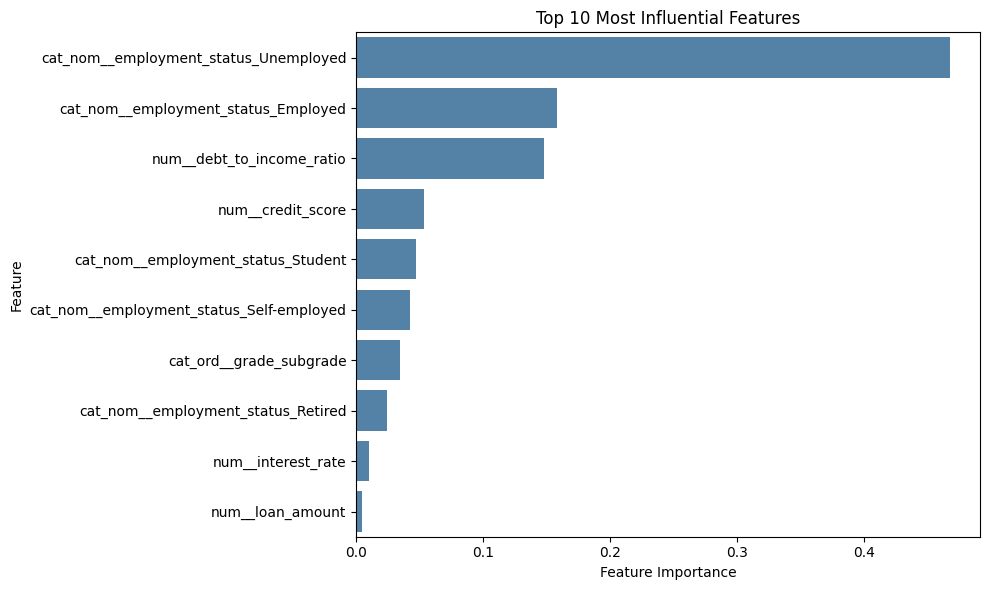

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------
# 1. Pull out transformed feature names from the pipeline
# -------------------------------------------------------
all_features = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# -------------------------------------------------------
# 2. Retrieve importance scores from the RF model
# -------------------------------------------------------
rf_importance_values = model_pipeline.named_steps['classifier'].feature_importances_

# -------------------------------------------------------
# 3. Build a tidy DataFrame for ranking
# -------------------------------------------------------
importance_table = pd.DataFrame({
    "feature_name": all_features,
    "importance_score": rf_importance_values
})

# -------------------------------------------------------
# 4. Select the top 10 most influential predictors
# -------------------------------------------------------
top_features = (
    importance_table
    .sort_values("importance_score", ascending=False)
    .iloc[:10]
)

# -------------------------------------------------------
# 5. Plot (now using BLUE bars)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features,
    x="importance_score",
    y="feature_name",
    color='steelblue'      # <--- BLUE COLOR APPLIED HERE
)

plt.title("Top 10 Most Influential Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
